# NLP HuggingFace Model With Probabilities based off of Plutchick Models

The [Plutchik Model of Emotions](https://pmc.ncbi.nlm.nih.gov/articles/PMC8409663/) is a popular basis for emotion visualization. Thus, a classification model based off this model could help give people insight into their emotions. We'll use a DistilBERT model due it's simplicity as a base, evaluate our model on test data and then build a function that uses a sigmoid activation function to calculate probabilities


In [3]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, TrainingArguments, Trainer, TrainerCallback

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F



ModuleNotFoundError: No module named 'datasets'

# Data Preprocessing

In [38]:
import pandas as pd
df1 = pd.read_parquet("hf://datasets/hemanthkotaprolu/goemotions-plutchiks/data/train-00000-of-00001.parquet")
# Neccesaary Downstream
df1 = df1.rename({"label": "labels"}, axis = 1)
df1

,input,labels
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
51580,"The last time it happened I just said, ""No"" an...",sadness
51581,"The last time it happened I just said, ""No"" an...",surprise
51582,I can’t stand this arrogant prick he’s no bett...,anger
51583,::but I like baby bangs:: /tiny voice,joy


In [69]:
df2 = pd.read_csv("hf://datasets/uavster/Llama3_8b-emotion_multiclass-Plutchik/emotions_llama3-8b-4bit_6540rows_robust07-filtered.csv", header = None)
df2 = df2.rename({0:"input"}, axis = 1)
df2

,input
0,"I just got tickets to my favorite concert.;""joy"""
1,"I finally got a promotion at work.;""joy"""
2,"I got a surprise visit from my best friend.;""joy"""
3,My favorite book series is being adapted into ...
4,I just finished a difficult project and I feel...
...,...
6535,"My favorite food is pizza, but I also eat othe..."
6536,I don't have any strong feelings about this ne...
6537,"I'm okay with going to the movies tonight.;""ne..."
6538,I don't really have an opinion on that matter....


In [70]:
# Extract label from str
def extract_word_in_quotes(text):
  """
  Get quotation label from string in dataframe if it's one of words in sent9
  """
  sent9= ['joy' ,'sadness', 'trust', 'disgust' ,'fear' ,'anger', 'surprise', 'anticipation', 'neutral']
  match = re.findall(r'\;"([^"]*)"', text)
  extracted_words = [word for word in match if word in sent9]

  return extracted_words[0] if extracted_words else "None"


df2['labels'] = df2['input'].apply(extract_word_in_quotes)
# Remove label from str

def remove_label(text):
  sent9= ['joy' ,'sadness', 'trust', 'disgust' ,'fear' ,'anger', 'surprise', 'anticipation', 'neutral']
  for label in sent9:
    text = re.sub(rf";\"\b{label}\b\"$", "", text).strip()
  return text

df2['input'] = df2['input'].apply(lambda x: remove_label(x))

# Sanity Check
df2['labels'].value_counts()

,count
labels,
anticipation,946
disgust,838
neutral,812
sadness,748
anger,743
trust,735
joy,611
fear,579
surprise,528


In [72]:
df2

,input,labels
0,I just got tickets to my favorite concert.,joy
1,I finally got a promotion at work.,joy
2,I got a surprise visit from my best friend.,joy
3,My favorite book series is being adapted into ...,joy
4,I just finished a difficult project and I feel...,joy
...,...,...
6535,"My favorite food is pizza, but I also eat othe...",neutral
6536,I don't have any strong feelings about this ne...,neutral
6537,I'm okay with going to the movies tonight.,neutral
6538,I don't really have an opinion on that matter.,neutral


In [73]:
df_final = pd.concat([df1, df2]).reset_index(drop=True)
df_final

,input,labels
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
58120,"My favorite food is pizza, but I also eat othe...",neutral
58121,I don't have any strong feelings about this ne...,neutral
58122,I'm okay with going to the movies tonight.,neutral
58123,I don't really have an opinion on that matter.,neutral


In [75]:
model_name = "distilbert-base-uncased"  # Arbitrary
# Extract unqiue Labels and aLphabetize
unique_labels = df_final['labels'].unique()
# Alphabetize
unique_labels = sorted(unique_labels)
# Put neutral at the end. Easier later
unique_labels.remove('neutral')
unique_labels.append('neutral')

num_labels = len(unique_labels)

from transformers import AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, TrainingArguments, Trainer, TrainerCallback

# Create mappings
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, label2id = label2id, id2label=id2label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Loading Model

In [76]:
from datasets import Dataset
dataset = Dataset.from_pandas(df_final)

state = 65
# Shuffle dataset before splitting
dataset = dataset.shuffle(seed=state)

# Split to Train and Test Data
train_test = dataset.train_test_split(test_size=0.2, seed=state) # 0.2 to test

# Assign splits
final_dataset = {
    "train": train_test["train"],
    "test": train_test["test"]
}

def preprocess_function(examples):
    return tokenizer(examples["input"], truncation=True, padding="max_length")

encoded_dataset = {split: dataset.map(preprocess_function, batched=True) for split, dataset in final_dataset.items()}

# Neccsary for Trainer
def encode_labels(data):
    """
    Turn string labels to previously defined labels to work with our trainer
    """
    data['labels'] = label2id[data['labels']]
    return data

encoded_dataset = {
    split: encoded_dataset[split].map(encode_labels)
    for split in encoded_dataset
}

encoded_dataset

Map:   0%|          | 0/46500 [00:00<?, ? examples/s]

Map:   0%|          | 0/11625 [00:00<?, ? examples/s]

Map:   0%|          | 0/46500 [00:00<?, ? examples/s]

Map:   0%|          | 0/11625 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 46500
 }),
 'test': Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 11625
 })}

In [78]:
total_samples = len(df_final)

class_weights = {cls: total_samples / (num_labels * sum(df_final['labels'] == cls)) for cls in unique_labels}
weights = torch.tensor(list(class_weights.values()), dtype=torch.float).to("cuda")


# Neccssary for weighted loss function
class CustomTrainer(Trainer):
    def __init__(self, *args,  class_weights=None, **kwargs):
        self.class_weights = class_weights
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get('labels') # It has to be labels, it won't accept any other string
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



training_args = TrainingArguments(
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="no",
    save_strategy="epoch",
    load_best_model_at_end=False,
    label_names = list(label2id.keys()),
    fp16=True,
    disable_tqdm = False, # Display Bars
    dataloader_num_workers=4
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    tokenizer=tokenizer,
    class_weights = weights
)


trainer.train()

Step,Training Loss
500,1.866400
1000,1.533600
1500,1.460300
2000,1.411600
2500,1.395500
3000,1.329000
3500,1.246800
4000,1.210500
4500,1.203300
5000,1.218100


TrainOutput(global_step=8721, training_loss=1.26406415587868, metrics={'train_runtime': 1827.7509, 'train_samples_per_second': 76.323, 'train_steps_per_second': 4.771, 'total_flos': 1.8481508964864e+16, 'train_loss': 1.26406415587868, 'epoch': 3.0})

              precision    recall  f1-score   support

       anger       0.48      0.56      0.51       857
anticipation       0.40      0.59      0.47       669
     disgust       0.51      0.65      0.57       421
        fear       0.42      0.58      0.49       390
         joy       0.39      0.45      0.42      1179
     sadness       0.39      0.52      0.45      1137
    surprise       0.35      0.41      0.38      1494
       trust       0.55      0.43      0.48      1647
     neutral       0.71      0.50      0.59      3831

    accuracy                           0.49     11625
   macro avg       0.47      0.52      0.48     11625
weighted avg       0.53      0.49      0.50     11625



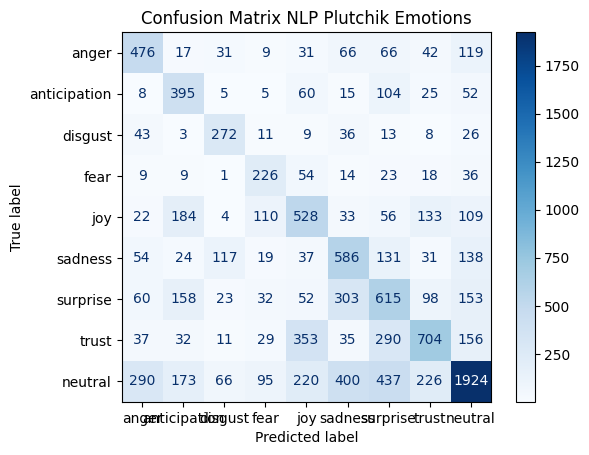

In [86]:
# pred = trainer.predict(encoded_dataset["test"])
# preds = pred.predictions[1].argmax(-1)
print(classification_report(encoded_dataset['test']['labels'], preds, target_names=list(label2id.keys())))

# Compute the confusion matrix
cm = confusion_matrix(encoded_dataset['test']['labels'], preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix NLP Plutchik Emotions")
plt.show()

In [87]:
def predict_with_confidence(text, model,id2label:dict, threshold = 0.5, device = 'cuda'):
    """
    Take string and predict with confidence what percentage each phrase falls into each label. Enocde exiting ids back to labels
    """
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = F.sigmoid(outputs.logits)

    # Replace below threshold with 0
    probs = torch.where(probs >= threshold, probs, torch.tensor(0.0))

    # Reencode with labels
    label_prob = {}
    for i in range(len(probs[0])):
      label_prob[id2label[i]] = float(probs[0][i])

    return label_prob

text = "Ya me! Except not? Idk what to right here oops. I made a model!"
confidence_scores = predict_with_confidence(text, model,id2label)
print(confidence_scores)  # List of confidence percentages

{'anger': 0.0, 'anticipation': 0.9645892381668091, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'sadness': 0.0, 'surprise': 0.9162596464157104, 'trust': 0.5406813025474548, 'neutral': 0.5579958558082581}


# Exporting

In [88]:
# Save Folders
trainer.save_model("Plutchik_Model_v1/")
tokenizer.save_pretrained("Plutchick_Model_Tokenizer_v1/")

('Plutchick_Model_Tokenizer_v1/tokenizer_config.json',
 'Plutchick_Model_Tokenizer_v1/special_tokens_map.json',
 'Plutchick_Model_Tokenizer_v1/vocab.txt',
 'Plutchick_Model_Tokenizer_v1/added_tokens.json',
 'Plutchick_Model_Tokenizer_v1/tokenizer.json')

In [89]:
# Zip files
!zip -r Plutchik_Model_v1.zip Plutchik_Model_v1/
!zip -r Plutchick_Model_Tokenizer_v1.zip Plutchick_Model_Tokenizer_v1/

from google.colab import files

files.download('Plutchik_Model_v1.zip')
files.download('Plutchick_Model_Tokenizer_v1.zip')

  adding: Plutchik_Model_v1/ (stored 0%)
  adding: Plutchik_Model_v1/special_tokens_map.json (deflated 42%)
  adding: Plutchik_Model_v1/tokenizer_config.json (deflated 75%)
  adding: Plutchik_Model_v1/vocab.txt (deflated 53%)
  adding: Plutchik_Model_v1/training_args.bin (deflated 51%)
  adding: Plutchik_Model_v1/model.safetensors (deflated 8%)
  adding: Plutchik_Model_v1/tokenizer.json (deflated 71%)
  adding: Plutchik_Model_v1/config.json (deflated 52%)
  adding: Plutchick_Model_Tokenizer_v1/ (stored 0%)
  adding: Plutchick_Model_Tokenizer_v1/special_tokens_map.json (deflated 42%)
  adding: Plutchick_Model_Tokenizer_v1/tokenizer_config.json (deflated 75%)
  adding: Plutchick_Model_Tokenizer_v1/vocab.txt (deflated 53%)
  adding: Plutchick_Model_Tokenizer_v1/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>